In [1]:
import numpy as np
import torch
from torch import nn
from torch.optim import Adam, SGD, lr_scheduler
from torch.utils.data import TensorDataset, ConcatDataset, Subset
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from itertools import chain

from tqdm import tqdm, trange
from matplotlib import pyplot as plt
from matplotlib import animation
from matplotlib.colors import Normalize
from IPython.display import HTML

In [2]:
BPTT_WINDOW = 3
PRED_WINDOW = 2
BATCH_SIZE = 8
CONFIG = dict(steps=3, dropout=0)

# Data

In [3]:
# convert numpy arrays to tensor
def to_tensor(ar):
    return torch.tensor(ar, dtype=torch.float)

data = to_tensor(np.load('dataTM.npy')[:,:-3])
mask = to_tensor(np.load('mask.npy')).cuda()
avg = to_tensor(np.load('avg.npy')).cuda()
base = to_tensor(np.load('base.npy'))
print(data.shape)

torch.Size([791, 6, 824, 200])


In [4]:
# get subset dataset for time serias fitting
def get_subseter(dataset, bptt_len):
    indices = [np.arange(i, i + bptt_len) for i in range(len(dataset)-bptt_len)]
    return Subset(dataset, indices)

# get splitted datasets from loaded tensor data
def get_datasets(bptt_len=6, pred_len=3):
    p = pred_len
    train1 = get_subseter(TensorDataset(data[:200-p], base[:200-p], data[p:200, 0]), bptt_len)
    train2 = get_subseter(TensorDataset(data[334: 560-p], base[334: 560-p], data[p+334: 560, 0]), bptt_len)
    val = get_subseter(TensorDataset(data[699: 750-p], base[699: 750-p], data[p+699: 750, 0]), bptt_len)
    test = get_subseter(TensorDataset(data[699:-p], base[699:-p], data[p+699:, 0]), bptt_len)
    return train1, train2, val, test

# get data loaders, mask of the river and mean frame 
def get_all(shuffle=True):
    # loaders, shape is x:(batch, time, channel, height, width) y:(batch, time, height, width)
    train1, train2, val, test = [
        DataLoader(dataset, BATCH_SIZE, sampler=RandomSampler(dataset) if shuffle else SequentialSampler(dataset)) \
        for dataset in get_datasets(BPTT_WINDOW, PRED_WINDOW)]
    return (train1, train2), val, test

# Models
Cells predict the whole channels, TSWrapper stores them but returns only radars, UDWrapper provides decorator for down-upsampling.

UN, EUN, TMUN, TMCN

In [5]:
def ffill(inputs, state): # TODO: maybe add more weight
    '''Fullfill missed regions in inputs with state.
    inputs shape: batch, channel, height, width
    ''' 
    out = inputs[:,:1] + state[:,:1] * (inputs[:,:1] <= 0)
    return torch.cat((out, inputs[:,1:]), 1)

class TSWrapper(nn.Module):
    '''Wraps Cell into time serias model'''
    def __init__(self, cell, avg_state, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.cell = cell
        self.avg_state = avg_state

    def forward(self, inputs, prestate=None):
        '''Forcasts up to PRED_WINDOW days in the future.
        inputs shape: batch, window, channel, height, width
        '''
        # x = prestate if prestate is not None else self.avg_state
        # outputs = []
        # for i in range(inputs.shape[1]):
        #     x = ffill(inputs[:,i], x)
        #     x = self.cell(x)
        # return x
        x = self.avg_state if prestate is None else prestate
        outputs = []
        # warming model
        for i in range(inputs.shape[1]):
            x = ffill(inputs[:,i], x)
            x = self.cell(x)
            outputs.append(x[:,0])
        # forecast
        for i in range(PRED_WINDOW-1):
            x = self.cell(x)
            outputs.append(x[:,0])
        return torch.stack(outputs[PRED_WINDOW-1:]).transpose(0,1)

class DUWrapper(nn.Module):
    '''Downsamples imputs for wrapped model and upsample it after'''
    def __init__(self, body, down=None, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.down = down or nn.AvgPool2d(2, 2)
        self.body = body
        self.up = nn.Upsample(scale_factor=2, mode='bicubic')
    
    def forward(self, inputs):
        return self.up(self.body(self.down(inputs)))

class DoubleConv2d(nn.Module):
    '''U-Net basic block'''
    def __init__(self, channels, hidden, dropout=0, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.block = nn.Sequential(
            nn.Conv2d(channels, hidden, 3, padding=1),
            nn.BatchNorm2d(hidden),
            nn.ReLU(True),
            nn.Dropout2d(dropout),
            nn.Conv2d(hidden, hidden, 3, padding=1),
            nn.BatchNorm2d(hidden),
            nn.ReLU(True)
        )
        
    def forward(self, inputs):
        return self.block(inputs)


In [6]:
class FFN(nn.Module):
    '''U-net ODU'''
    def __init__(self, steps=1, channels=9, hidden=64, dropout=0, residual=False, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        dropout /= steps
        self.residual = residual
        self.steps = steps
        self.encoder = DoubleConv2d(channels, hidden, dropout)
        self.decoder = DoubleConv2d(hidden, channels, dropout)

    def forward(self, inputs):
        x = inputs
        for _ in range(self.steps):
            m = self.encoder(x)
            x = x*self.residual + self.decoder(m)
        return x

class EUN(nn.Module):
    '''U-net ODU'''
    def __init__(self, steps=1, channels=9, hidden=64, dropout=0, residual=False, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        dropout /= steps
        self.residual = residual
        self.steps = steps
        self.encoder = DoubleConv2d(channels, hidden, dropout)
        self.neck = DUWrapper(DoubleConv2d(hidden, hidden*2, dropout), nn.MaxPool2d(2, 2))
        self.decoder = DoubleConv2d(hidden*3, channels, dropout)

    def forward(self, inputs):
        x = inputs
        for _ in range(self.steps):
            m = self.encoder(x)
            m = torch.cat((m, self.neck(m)), dim=1)
            x = x*self.residual + self.decoder(m)
        return x
    
class TMUN(nn.Module):
    '''U-net ODU with physics inspired connections'''
    def __init__(self, steps=1, channels=12, hidden=64, dropout=0, residual=False, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        dropout /= steps
        self.residual = residual
        self.steps = steps
        self.encoder = DoubleConv2d(channels, hidden, dropout)
        self.subcoder = nn.Conv2d(channels, hidden, 1)
        self.neck = DUWrapper(DoubleConv2d(hidden, hidden, dropout), nn.MaxPool2d(2, 2))
        self.decoder = DoubleConv2d(hidden*3, channels, dropout)

    def forward(self, inputs):
        x = inputs
        for _ in range(self.steps):
            m = self.encoder(x)
            v = self.subcoder(x)
            m = torch.cat((m, self.neck(m), m*v), dim=1)
            x = x*self.residual + self.decoder(m)
        return x
    
class TMCN(nn.Module):
    '''Physics inspired polynomial-convolutional network '''
    def __init__(self, steps=1, channels=12, hidden=64, dropout=0, residual=False, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        dropout /= steps
        self.hidden = hidden
        self.residual = residual
        self.steps = steps
        self.encoder = DoubleConv2d(channels, hidden*2, dropout)
        self.subcoder = nn.Conv2d(channels, hidden*2, 1)
        self.neck = DUWrapper(DoubleConv2d(hidden*2, hidden, dropout), nn.MaxPool2d(2, 2))
        self.decoder = nn.Conv2d(hidden*5, channels, 1)

    def forward(self, inputs):
        x = inputs
        for _ in range(self.steps):
            m = self.encoder(x)
            v = self.subcoder(x)
            vv = v[:,:self.hidden]*v[:,self.hidden:]
            m = torch.cat((v, v*m, vv*self.neck(m)), dim=1)
            x = x*self.residual + self.decoder(m)
        return x
    
class UN(nn.Module):
    '''just U-net'''
    def __init__(self, channels=9, hidden=64, dropout=0, **kwargs) -> None:
        super().__init__()
        self.encoder1 = DoubleConv2d(channels, hidden, dropout)
        self.encoder2 = nn.Sequential(
            nn.MaxPool2d(2, 2),
            DoubleConv2d(hidden, hidden*2, dropout))
        
        self.neck = DUWrapper(down=nn.MaxPool2d(2, 2), body=\
            DoubleConv2d(hidden*2, hidden*4, dropout))
        
        self.decoder2 = nn.Sequential(
            DoubleConv2d(hidden*6, hidden*2, dropout),
            nn.Upsample(scale_factor=2, mode='bicubic'))
        self.decoder1 = DoubleConv2d(hidden*3, channels, dropout)
    
    def forward(self, inputs):
        x = self.encoder1(inputs)
        x2 = self.encoder2(x)
        x2 = torch.cat((x2, self.neck(x2)), dim=1)
        x2 = self.decoder2(x2)
        x = self.decoder1(torch.cat((x2, x), dim=1))
        return x
    
class TMBlock(nn.Module):
    def __init__(self, dropout=0):
        super().__init__()
        self.d = nn.Conv2d(6, 6, 3, padding=1)
        self.v = nn.Conv2d(2, 6, 1)
        self.i = nn.Sequential(nn.Dropout(dropout), nn.Conv2d(36, 6, 1))
        # self.u = EUN(1, 6, 8, dropout, False)
        self.u = DoubleConv2d(6, 6, dropout)
        self.bn = nn.BatchNorm2d(6)
        self.act = nn.ReLU()
        
    def forward(self, x):
        b,c,h,w = x.shape
        di = self.v(x[:,2:4])*self.d(x) + self.i(torch.einsum('bchw,bshw->bcshw',x,x).reshape((b,c**2,h,w)))
        u = self.u(x)
        return self.act(self.bn(di+u))
    
class TMT(nn.Module):
    def __init__(self, steps=1, dropout=0):
        super().__init__()
        self.b1 = TMBlock(dropout)
        self.b2 = TMBlock(dropout)
        self.b3 = TMBlock(dropout)
        self.dec = DoubleConv2d(6*3, 6, dropout)
        self.steps = steps
        self.r = 0.1
                
    def forward(self, x):
        for _ in range(self.steps):
            x = x*self.r + self.dec(torch.cat((
                self.b1(x), self.b2(x), self.b3(x)
            ), 1)) / self.steps   
        return x

# Train

In [7]:
model = TSWrapper(DUWrapper(TMT(**CONFIG)), avg).cuda()
# model.load_state_dict(torch.load('points/TMT22'))

opt = Adam(model.parameters(), 1e-2)
loss, val_loss, grads = [], [], []

# lineary reweight in a way that sum of the weights remains
def wmse(y_pred, y_true):
    return torch.mean(((y_pred*(y_true>0) - y_true)*mask)**2)

trains, val, test = get_all(shuffle=True)

In [8]:
# sch = lr_scheduler.ReduceLROnPlateau(opt, factor=0.7)

In [ ]:
t = trange(200)
for _ in t:
    tl, vl, grad = [], [], []
    
    # train round
    model.train()
    for X, b, y in chain(*trains):
        # l = wmse(model(X.cuda(), b[:,0].cuda()), y.cuda())
        l = wmse(model(X.cuda()), y.cuda())
        opt.zero_grad(); l.backward(); opt.step()
        tl.append(l.detach().cpu().item())

        for tag, value in model.named_parameters():
            if value.grad is not None:
                grad.append(value.grad.norm().cpu().item())
    # val round
    model.eval()
    with torch.no_grad():
        for X, b, y in val:
            # l = wmse(model(X.cuda(), b[:,0].cuda()), y.cuda()).detach().cpu().item()
            l = wmse(model(X.cuda()), y.cuda()).detach().cpu().item()
            vl.append(l)
    tl, vl, grad = np.mean(tl), np.mean(vl), np.mean(grad)
    loss.append(tl); val_loss.append(vl); grads.append(grad)
    t.set_postfix(loss=tl, val_loss=vl, grad=grad)
    # sch.step(tl)

  2%|▏         | 3/200 [01:16<1:23:22, 25.39s/it, grad=0.00134, loss=0.00845, val_loss=0.0262]

Text(0, 0.5, 'полнота кадра')

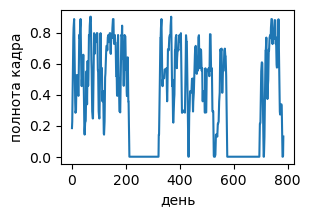

In [104]:
rads = data[:,0]
plt.figure(figsize=(3,2))
plt.plot(np.convolve((rads>0).sum((1,2))/(824*200), np.ones(7)/7, mode='valid'))
plt.xlabel('день')
plt.ylabel('полнота кадра')

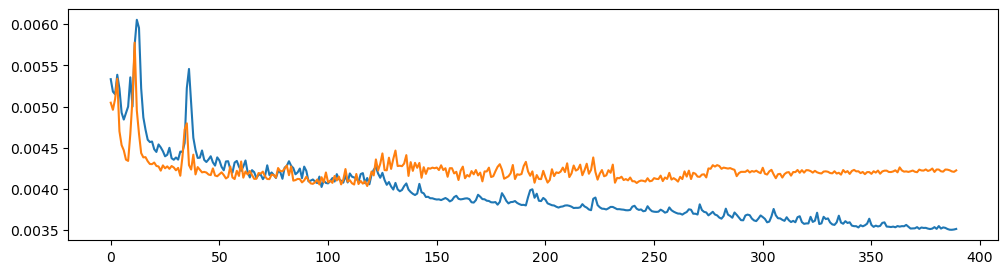

In [95]:
plt.figure(figsize=(12,3))
plt.plot(loss[10:])
plt.plot(val_loss[10:])
# plt.plot(grads[5:])

In [75]:
# torch.save(model.state_dict(), r'points/TMT22')

# Evaluate

In [34]:
# train, val, test = get_all(shuffle=False)
model.eval()
None

In [37]:
pred, targ, loss = [], [], []
with torch.no_grad():
    for X, y in test:#chain(*train):
        y_pred = model(X.cuda())
        loss.append(wmse(y_pred, y.cuda()).cpu().item())
        pred.append((y_pred*mask).detach().cpu())
        targ.append(y.cpu()*mask.cpu())
pred, targ = np.clip(torch.concat(pred, 0).numpy(),0,1), torch.concat(targ, 0).numpy()
diff = (pred-targ)*(targ>0)
print(np.mean(loss), max(np.abs(diff.min()), diff.max()))

0.005897875457509037 0.9981935


In [14]:
fig = plt.figure(figsize=(10, 8))
ax = fig.subplots(3, BPTT_WINDOW)
predim, targim, difim = [], [], []
for im, row, imgs, norm in zip((predim, targim, difim), ax, (pred, targ, diff), (Normalize(0,1), Normalize(0,1), Normalize(-1, 1))):
    for i in range(BPTT_WINDOW):
        im.append(row[i].imshow(imgs[0, i], norm=norm))
        row[i].axis('off')
plt.close()

def init():
    for i, sim in enumerate(predim):
        sim.set_data(pred[0, i])
    for i, sim in enumerate(targim):
        sim.set_data(targ[0, i])
    for i, sim in enumerate(difim):
        sim.set_data(diff[0, i])

def animate(i):
    for ims, imgs in zip((predim, targim, difim), (pred, targ, diff)):
        for j, im in enumerate(ims):
            im.set_data(imgs[i, j])
    return (predim, targim)

anim = animation.FuncAnimation(fig, animate, init_func=init, frames=pred.shape[0], interval=500)
HTML(anim.to_html5_video())

In [65]:
anim.save('points/EU1-tr2.mp4', writer = animation.FFMpegWriter())